# Lab 3: Adding Router & Skill Evaluations

In this lab, you will implement the following evaluators to assess the performance of the router and the tools:
- an LLM-as-a-judge to evaluate the correctness of the router's function calling choice and the correctness of the parameters extracted;
- an LLM-as-a-judge to evaluate the correctness of the SQL generated by tool 1 and the clarity of the analysis generated by tool 2;
- a code-based evaluator to verify if the code generated by tool 3 is runnable. 


<img src="images/router_skill_eval.png" width="700"/>


## Importing necessary libraries 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import json
from tqdm import tqdm
from phoenix.evals import (
    TOOL_CALLING_PROMPT_TEMPLATE, # default tool calling prompt template
    llm_classify, # llm-as-a-judge evaluator
    OpenAIModel
)
from phoenix.trace import SpanEvaluations
from phoenix.trace.dsl import SpanQuery
from phoenix.client import Client  # Phoenix 12.x Client
from openinference.instrumentation import suppress_tracing

# Import Azure OpenAI configuration helper
from helper import get_azure_openai_evaluation_configurations

# to run some code evaluations in the notebook simultaneously to speed up the process
import nest_asyncio
nest_asyncio.apply()

You'll use `llm_classify` to define your LLM-as-a-judge evaluator. OpenAIModel is a class that wraps the OpenAI model, and you can use it to define and pass the model objects to `llm_classify`.

For Azure OpenAI, you need to configure the model with Azure-specific parameters.

In [ ]:
# Must match the project name used in utils.py
from utils import PROJECT_NAME

In [ ]:
import phoenix as px
from phoenix.session.session import launch_app

# start the phoenix instance

# 12.x phoenix version runs this way
session = launch_app()

In [ ]:
from utils import run_agent, start_main_span, tools, get_phoenix_endpoint

The utils file contains the same instrumented agent code that you worked on in the previous lab. 

<p style="background-color:#grey; padding:15px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px"> 💻 &nbsp; <b>Access <code>requirements.txt</code>, <code>utils.py</code> and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>. For more help, please see the <em>"Appendix – Tips, Help, and Download"</em> Lesson.</p>

<p style="background-color:#grey; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 🚨
&nbsp; <b>Different Run Results:</b> The output generated by AI chat models can vary with each execution due to their dynamic, probabilistic nature. Your results might differ from those shown in the video.</p>

## Running Agent with a Set of Testing Questions

To evaluate your agent's components, you will run the agent using a set of questions. For each question, you will collect spans and send them to Phoenix. Next to evaluate an agent component, you will query some specific spans and use them as your testing examples for your evaluators. Finally, you will upload the evaluated spans to Phoenix.

<img src="images/traces.png" width="400"/>

In [ ]:
# Create Phoenix client once for the entire notebook (Phoenix 12.x)
# Used in all the following cells to query spans and log evaluations
phoenix_client = Client()

In [ ]:
agent_questions = [
    "What was the most popular product SKU?",
    "What was the total revenue across all stores?",
    "Which store had the highest sales volume?",
    "Create a bar chart showing total sales by store",
    "What percentage of items were sold on promotion?",
    "What was the average transaction value?"
]

for question in tqdm(agent_questions, desc="Processing questions"):
    try:
        ret = start_main_span([{"role": "user", "content": question}])
    except Exception as e:
        print(f"Error processing question: {question}")
        print(e)
        continue

## Link to Phoenix UI

You can open this link to check out the Phoenix UI and observe the collected spans. You can use the same link to check out the results of the evaluations you'll run in this notebook. 

**Note**: 
- Since each notebook of this course runs in an isolated environment, each notebook links to a different Phoenix server. This is why you won't see the project "tracing-agent" you worked on in the previous notebook (as shown in the video).
- Make sure that the notebook's kernel is running when checking the Phoenix UI. If the link does not open, it might be because the notebook has been open or inactive for a long time. In that case, make sure to refresh the browser, run all previous cells and then check this link. 

In [ ]:
print(get_phoenix_endpoint())

## Router Evals using LLM-as-a-Judge

To evaluate the router, you will use this template provided by Phoenix to the LLM-as-a-Judge. 

In [ ]:
print(TOOL_CALLING_PROMPT_TEMPLATE)

### Querying the Required Spans

In [ ]:
query = SpanQuery().where(
    # Filter for the `LLM` span kind.
    # The filter condition is a string of valid Python boolean expression.
    "span_kind == 'LLM'",
).select(
    question="input.value",
    tool_call="llm.tools"
)

# Phoenix 12.x API - use the reused client
tool_calls_df = phoenix_client.spans.get_spans_dataframe(
    query=query, 
    project_name=PROJECT_NAME,
    timeout=None
)
tool_calls_df = tool_calls_df.dropna(subset=["tool_call"])

tool_calls_df.head()

In [ ]:
# Debug: Check if tool_calls_df has data
print(f"tool_calls_df shape: {tool_calls_df.shape}")
print(f"tool_calls_df columns: {tool_calls_df.columns.tolist()}")
print(f"\nFirst few rows:")
tool_calls_df.head()

EVALUATING THE TOOL CALLS AND THE REST USING EVALUATION MODEL WE CREATE SEPARATELY

Before Evaluating the tool calls using Azure OpenAI, we have to create the OpenAI client which points the Azure OpenAI endpoint.

In [ ]:
# Configure Azure OpenAI model for Phoenix evaluations
eval_config = get_azure_openai_evaluation_configurations()

eval_model = OpenAIModel(
    model=eval_config.model,
    api_key=eval_config.api_key,
    azure_endpoint=eval_config.azure_endpoint,
    azure_deployment=eval_config.deployment,
    api_version=eval_config.api_version
)

In [ ]:
with suppress_tracing():
    tool_call_eval = llm_classify(
        dataframe = tool_calls_df,
        template = TOOL_CALLING_PROMPT_TEMPLATE.template[0].template.replace("{tool_definitions}", 
                                                                 json.dumps(tools).replace("{", '"').replace("}", '"')),
        rails = ['correct', 'incorrect'], # the possible output labels
        model=eval_model,
        provide_explanation=True
    )

tool_call_eval['score'] = tool_call_eval.apply(lambda x: 1 if x['label']=='correct' else 0, axis=1)

tool_call_eval.head()

Then after aggregating results in llm_classify, we need to move them back to Phoenix using the Phoenix client using `log_span_annotations_dataframe`. It allows us to see results on Phoenix UI.

Evaluation metric appears on the UI:
![image.png](attachment:03df75ef-f54a-4159-9cf9-bab8e8f19711.png)

In [ ]:
# Phoenix 12.x API: log evaluations as annotations
span_evals = SpanEvaluations(eval_name="Tool Calling Eval", dataframe=tool_call_eval)
phoenix_client.spans.log_span_annotations_dataframe(
    dataframe=span_evals.dataframe,
    annotation_name=span_evals.eval_name,
    annotator_kind="LLM"  # LLM-as-a-judge evaluator
)

![image.png](attachment:314d675b-673b-4b59-888a-3bbf811c0301.png)

Feedback panel becomes available after sending back the evaluations to Phoenix

## Evaluating Python Code Gen (Tool 3 - Data Visualization Evals)

In [ ]:
query = SpanQuery().where(
    "name =='generate_visualization'" # this is how we filter what we want to use in the query. Here we want to find all generate_visualization spans
).select(
    generated_code="output.value" # and we want to export the output.value for each found span
)

# Phoenix 12.x API - use the reused client
code_gen_df = phoenix_client.spans.get_spans_dataframe(
    query=query, 
    project_name=PROJECT_NAME,
    timeout=None
)

code_gen_df.head()

In [ ]:
# evaluation if this code is runnable
def code_is_runnable(output: str) -> bool:
    """Check if the code is runnable"""
    output = output.strip()
    output = output.replace("```python", "").replace("```", "")
    try:
        exec(output)
        return True
    except Exception as err:
        print("error: %s", err)
        return False

In [ ]:
# this code assigns labels and scores based on whether the code is runnable or not
# code_is_runnable function is called for each generated_code and function returns True or False
code_gen_df["label"] = code_gen_df["generated_code"].apply(code_is_runnable).map({True: "runnable", False: "not_runnable"})
code_gen_df["score"] = code_gen_df["label"].map({"runnable": 1, "not_runnable": 0})


Will be something like this
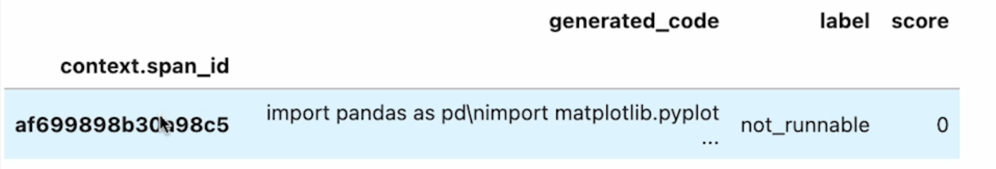

In [ ]:
code_gen_df.head()

Now we can upload the results back to Phoenix using the Phoenix client using `log_span_annotations_dataframe`. It allows us to see results on Phoenix UI.

In [ ]:
# Phoenix 12.x API: log evaluations as annotations
span_evals = SpanEvaluations(eval_name="Runnable Code Eval", dataframe=code_gen_df)
phoenix_client.spans.log_span_annotations_dataframe(
    dataframe=span_evals.dataframe,
    annotation_name=span_evals.eval_name,
    annotator_kind="CODE"  # Code-based evaluator
)

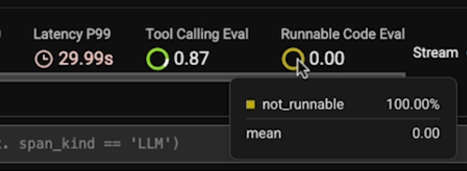

## Evaluating Analysis Clarity (Tool 2 - Data Analysis Evals)
This LLM as a Judge evaluator is needed because there is no necessary prompt for that integrated into Phoenix (but probably could be found in version 12.x+, was not found for 7.x+)

In [ ]:
CLARITY_LLM_JUDGE_PROMPT = """
In this task, you will be presented with a query and an answer. Your objective is to evaluate the clarity 
of the answer in addressing the query. A clear response is one that is precise, coherent, and directly 
addresses the query without introducing unnecessary complexity or ambiguity. An unclear response is one 
that is vague, disorganized, or difficult to understand, even if it may be factually correct.

Your response should be a single word: either "clear" or "unclear," and it should not include any other 
text or characters. "clear" indicates that the answer is well-structured, easy to understand, and 
appropriately addresses the query. "unclear" indicates that some part of the response could be better 
structured or worded.
Please carefully consider the query and answer before determining your response.

After analyzing the query and the answer, you must write a detailed explanation of your reasoning to 
justify why you chose either "clear" or "unclear." Avoid stating the final label at the beginning of your 
explanation. Your reasoning should include specific points about how the answer does or does not meet the 
criteria for clarity.

[BEGIN DATA]
Query: {query}
Answer: {response}
[END DATA]
Please analyze the data carefully and provide an explanation followed by your response.

EXPLANATION: Provide your reasoning step by step, evaluating the clarity of the answer based on the query.
LABEL: "clear" or "unclear"
"""

In [ ]:
query = SpanQuery().where(
    "span_kind=='AGENT'" # export relevant information filtering all spans by kind == 'AGENT'
).select(
    response="output.value", # export 2 things for each span: input.value and output.value
    query="input.value"
)

# Phoenix 12.x API - use the reused client
clarity_df = phoenix_client.spans.get_spans_dataframe(
    query=query,
    project_name=PROJECT_NAME,
    timeout=None
)

clarity_df.head()

Now lets run the evaluator using llm_classify and LLM-as-a-Judge to check the response clarity.

In [ ]:
with suppress_tracing():
    clarity_eval = llm_classify(
        dataframe = clarity_df,
        template = CLARITY_LLM_JUDGE_PROMPT,
        rails = ['clear', 'unclear'], # the possible labels configured for LLM as a Judge
        model=eval_model,  # Use configured Azure OpenAI model
        provide_explanation=True
    )

clarity_eval['score'] = clarity_eval.apply(lambda x: 1 if x['label']=='clear' else 0, axis=1)

clarity_eval.head()

In [ ]:
with suppress_tracing():
    clarity_eval = llm_classify(
        dataframe = clarity_df,
        template = CLARITY_LLM_JUDGE_PROMPT,
        rails = ['clear', 'unclear'],
        model=eval_model,
        provide_explanation=True
    )

clarity_eval['score'] = clarity_eval.apply(lambda x: 1 if x['label']=='clear' else 0, axis=1)

clarity_eval.head()

In [ ]:
# Phoenix 12.x API: log evaluations as annotations
span_evals = SpanEvaluations(eval_name="Response Clarity", dataframe=clarity_eval)
phoenix_client.spans.log_span_annotations_dataframe(
    dataframe=span_evals.dataframe,
    annotation_name=span_evals.eval_name,
    annotator_kind="LLM"  # LLM-as-a-judge evaluator
)

You should see something like this on Phoenix UI:
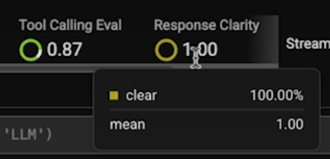

## Evaluating SQL Code Generation (Tool 1 - Database Lookup Evals)
We do almost the same as for clarity evals, but now we need to evaluate if the SQL query generated is correct or not.
We will see results separately for each evaluation.

In [ ]:
query = SpanQuery().where(
    "span_kind=='LLM'" # we filter for spans with kind LLM again
).select(
    query_gen="llm.output_messages", # again. specify the export fields for each span we find. llm.output_message and input.value
    question="input.value",
)

# Phoenix 12.x API - use the reused client
sql_df = phoenix_client.spans.get_spans_dataframe(
    query=query,
    project_name=PROJECT_NAME,
    timeout=None
)

# Filter down for SQL generation spans - match the actual prompt text in utils.py
# it's needed because above we filter only by span_kind=='LLM' which includes other LLM calls as well
sql_df = sql_df[sql_df["question"].str.contains("Generate a DuckDB SQL query based on a prompt", na=False)]

sql_df.head()

In [ ]:
SQL_EVAL_GEN_PROMPT = """
SQL Evaluation Prompt:
-----------------------
You are tasked with determining if the SQL generated appropriately answers a given instruction
taking into account its generated query and response.

Data:
-----
- [Instruction]: {question}
  This section contains the specific task or problem that the sql query is intended to solve.

- [Reference Query]: {query_gen}
  This is the sql query submitted for evaluation. Analyze it in the context of the provided
  instruction.

Evaluation:
-----------
Your response should be a single word: either "correct" or "incorrect".
You must assume that the db exists and that columns are appropriately named.
You must take into account the response as additional information to determine the correctness.

- "correct" indicates that the sql query correctly solves the instruction.
- "incorrect" indicates that the sql query correctly does not solve the instruction correctly.

Note: Your response should contain only the word "correct" or "incorrect" with no additional text
or characters.
"""

Supress Tracing is the method which calls llm_classify without tracing the calls in Phoenix.
Inside we use "provide_explanation" which is needed to enable explanation why the answer is market correct or incorrect.

In [ ]:
with suppress_tracing():
    sql_gen_eval = llm_classify(
        dataframe = sql_df,
        template = SQL_EVAL_GEN_PROMPT,
        rails = ['correct', 'incorrect'],
        model=eval_model, # Use configured Azure OpenAI model
        provide_explanation=True
    )

# we rely on our label rails declared above in the method llm_classify to assign scores
sql_gen_eval['score'] = sql_gen_eval.apply(lambda x: 1 if x['label']=='correct' else 0, axis=1)

sql_gen_eval.head()



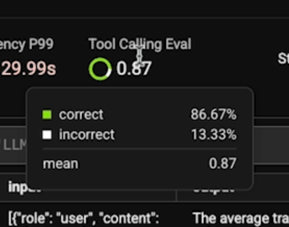

In [ ]:
# upload the data back to Phoenix using the Phoenix client using `log_span_annotations_dataframe`
# Phoenix 12.x API: upload log evaluations as annotations
span_evals = SpanEvaluations(eval_name="SQL Gen Eval", dataframe=sql_gen_eval)
phoenix_client.spans.log_span_annotations_dataframe(
    dataframe=span_evals.dataframe,
    annotation_name=span_evals.eval_name,
    annotator_kind="LLM"  # LLM-as-a-judge evaluator
)

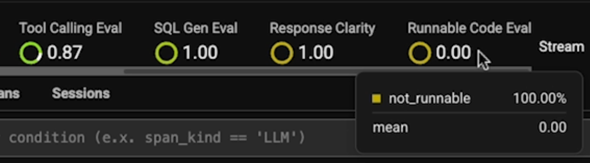

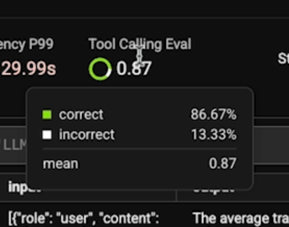